In [24]:

x_val_flat.shape


(1308, 49152)

### Imports & declarations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

LOCAL_PATH_MINI = '../data/raw/kaggle_mini_subsample'
LOCAL_PATH_TRAIN = '../data/raw/train'
COLAB_PATH_TRAIN = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
COLAB_PATH_MINI = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/mini_subsample'

RANDOM_STATE = 2020

# Comment when running locally, uncomment for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define basic functions

In [2]:
def make_flat(x):
    s = x.shape
    dim_0 = s[0]
    dim_1 = s[1]*s[2]*s[3]
    x_flat = x.reshape(dim_0, dim_1)
    shape = (x_flat.shape[1],)
    return x_flat, shape

In [3]:
def plot_results(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

## Mini Dataset

#### Import & Clean

In [4]:
# TESTING TO GET LABEL ENCODING CORRECT

path = COLAB_PATH_MINI
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(32, 32),
                                                class_names=['NORMAL', 'PNEUMONIA'],
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')
for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)


# print('Data shape:', images.shape)
# print('Label shape:', labels.shape)

Found 200 files belonging to 2 classes.
CLASS NAMES: ['NORMAL', 'PNEUMONIA'] CORRESPOND TO [0,1]


Found 200 images belonging to 2 classes.


'Example image:'

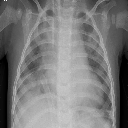

Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset shape: (200, 128, 128, 3)


In [5]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]

path = COLAB_PATH_MINI
image_generator = ImageDataGenerator().flow_from_directory(path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display('Example image:', array_to_img(images[0]))
print('Indices:', image_generator.class_indices)
print('Dataset shape:', images_scaled.shape)

#### Mini Dataset Model

Epoch 1/50
7/7 [==============================] - 14s 6ms/step - loss: 2.3126 - accuracy: 0.4826
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.6087
Epoch 3/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6597 - accuracy: 0.6368
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6547 - accuracy: 0.6230
Epoch 5/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6550 - accuracy: 0.6140
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6638 - accuracy: 0.5882
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6264 - accuracy: 0.6325
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6200 - accuracy: 0.6218
Epoch 9/50
7/7 [==============================] - 0s 5ms/step - loss: 0.5433 - accuracy: 0.6649
Epoch 10/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6214 - accuracy: 0.6021
Epoch 11/50
7/7 [=====================

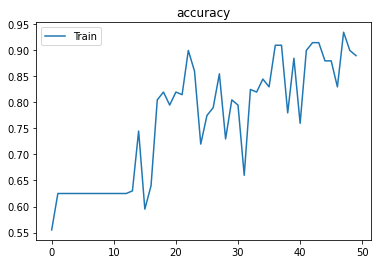

In [6]:
x, shape = make_flat(images_scaled)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=x, y=labels, epochs=50)

plot_results(history.history, val=False)

model.summary()

## Full Dataset

### Import and clean

In [7]:
path = COLAB_PATH_TRAIN
BATCH_SIZE = 32
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(128, 128), # Can work up to 256
                                                batch_size=BATCH_SIZE,
                                                class_names=['NORMAL', 'PNEUMONIA'],                                                
                                                seed=RANDOM_STATE)

print('CLASS NAMES:', data_tf.class_names, 'CORRESPOND TO [0,1]')

for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)

#data_tf = None # clear RAM
print('Data shape:', images.shape)
print('Label shape:', labels.shape)

Found 5232 files belonging to 2 classes.
CLASS NAMES: ['NORMAL', 'PNEUMONIA'] CORRESPOND TO [0,1]
6 %
12 %
18 %
24 %
30 %
36 %
42 %
48 %
55 %
61 %
67 %
73 %
79 %
85 %
91 %
97 %
Data shape: (5232, 128, 128, 3)
Label shape: (5232, 2)


In [8]:
# BATCH_SIZE_TRAIN = 1341+3875
# TARGET_SIZE = [256, 256]

# path = COLAB_PATH_TRAIN

# t0 = time.time()
# generator = ImageDataGenerator().flow_from_directory(path,
#                                                      #batch_size=BATCH_SIZE_TRAIN,
#                                                      target_size=TARGET_SIZE)

# images, labels = next(generator)
# images = images / 256
# t1 = time.time()

# print('Runtime:', t1-t0)
# print(images.shape, labels.shape)

CHANGE TERMINOLOGY TO FIRST SIMPLE MODEL, INSTEAD OF BASELINE. BASELINE IS RANDOM GUESS

Notes:
- Remove MSE

### Baseline Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10)                491530    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 491,552
Trainable params: 491,552
Non-trainable params: 0
_________________________________________________________________


None

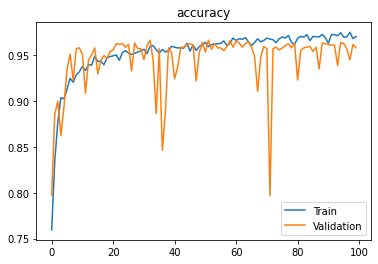

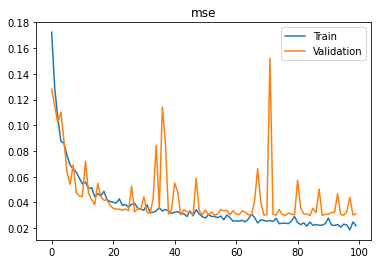

In [9]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(10, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')


history = model.fit(x=x, y=labels, 
                    epochs=100, 
                    verbose=0,
                    validation_split=0.25)

display(model.summary())


plot_results(history.history, ['accuracy', 'mse'])

### Define Early Stopping

In [10]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

### Entire train dataset, validation split

##### Create and fit model

In [ ]:
image_gen = keras.preprocessing.image.ImageDataGenerator()

In [ ]:
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

NOTE: TRY USING ADAM OR ADAMMAX INSTEAD OF SGD
ALSO LOOK INTO OTHER KERAS CALLBACKS

history = model.fit(x=x, y=labels, 
                    #callbacks = early_stopping,
                    epochs=500, 
                    validation_split=0.25, 
                    verbose=0)

#best_model = keras.models.load_model('best_model.h5')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                1572896   
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 1,572,962
Trainable params: 1,572,962
Non-trainable params: 0
_________________________________________________________________


None

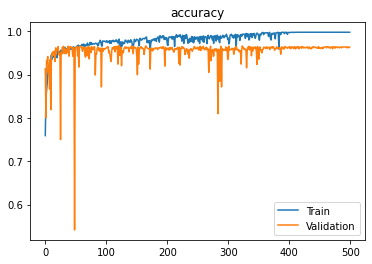

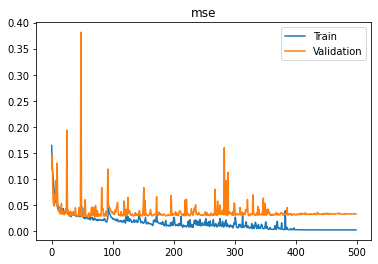

In [12]:
display(model.summary())

plot_results(history.history, ['accuracy', 'mse'])

### Create balanced dataset

In [13]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size = 0.25)
#images = None # clear memory

In [14]:
y_train.shape

(3924, 2)

In [32]:
print(ind_neg.sum())
print((y_train[:, 1]==1).sum())

1008
2916


In [39]:
img_gen = keras.preprocessing.image.ImageDataGenerator(COLAB_PATH_MINI)


model = Sequential()
model.add(Dense(8, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit_generator(img_gen, epochs=5)


plot_results(history.history, ['accuracy'], val=False)


model.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


ValueError: ignored

In [15]:
# Oversample the minority class: 
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversample_the_minority_class
np.random.seed(RANDOM_STATE)

ind_neg = y_train[:, 0]==1
ind_pos = y_train[:, 0]==0

neg_ct = ind_neg.sum()
pos_ct = ind_pos.sum()
# print('NORMAL count:', neg_ct, ', PNEUMONIA count:', pos_ct)

ids = np.arange(neg_ct)

# Select random entries from the list of inputs
ind_add_ons = np.random.choice(ids, size=pos_ct-neg_ct)
add_ons_x = x_train[ind_neg][ind_add_ons]
add_ons_y = y_train[ind_neg][ind_add_ons]

x_train_balanced = np.concatenate([x_train, add_ons_x], axis=0)
y_train_balanced = np.concatenate([y_train, add_ons_y], axis=0)
print('Training sizes after resampling:', x_train_balanced.shape, y_train_balanced.shape)
print('NORMAL count, PNEUMONIA count:', y_train_balanced.sum(axis=0))

# clear memory
# x_train = None
# y_train = None

NORMAL count: 1008 , PNEUMONIA count: 2916
Training sizes after resampling: (5832, 128, 128, 3) (5832, 2)
NORMAL count, PNEUMONIA count: [2916 2916]


### Create model with resampled dataset

In [18]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)

model = Sequential()
model.add(Convolutional()) # NOTE TO DO - INCORPORATE CONVOLUTIONAL LAYER
model.add(Dense(8, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 393224    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 18        
Total params: 393,242
Trainable params: 393,242
Non-trainable params: 0
_________________________________________________________________


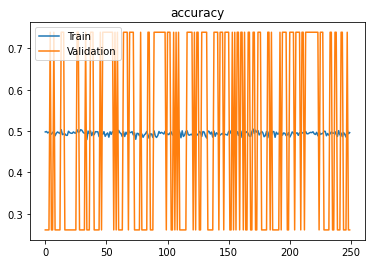

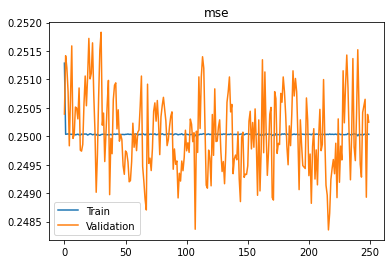

In [19]:
history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    epochs=250, 
                    validation_data=(x_val_flat, y_val),
                    verbose=0)

plot_results(history.history, ['accuracy', 'mse'])

model.summary()

### Add Regularization

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               12583168  
_________________________________________________________________
dense_11 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_12 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 34        
Total params: 12,600,690
Trainable params: 12,600,690
Non-trainable params: 0
_________________________________________________________________


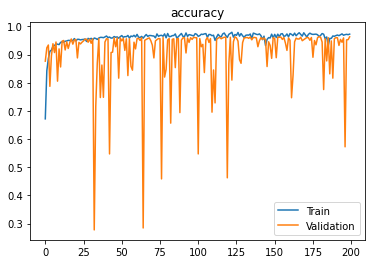

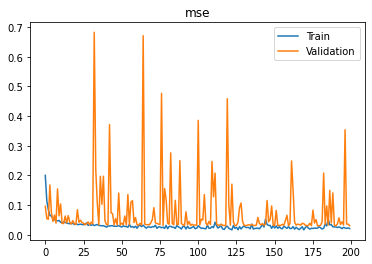

In [20]:
LAMBDA = 0.005

model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    callbacks=early_stopping, 
                    epochs=500, 
                    validation_data=(x_val_flat, y_val),
                    verbose=0)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Add Dropout

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 256)               12583168  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                

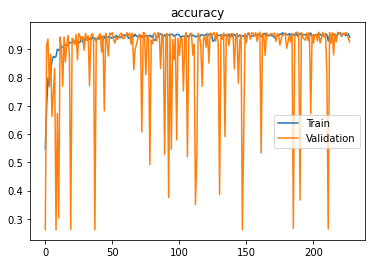

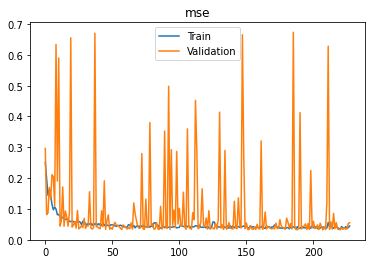

In [21]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)
early_stopping = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

LAMBDA = 0.005
DROPOUT = 0.3

t0 = time.time()


model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    callbacks=early_stopping, 
                    epochs=500,
                    validation_data=(x_val_flat, y_val), verbose=0)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

print('Full runtime:', time.time() - t0)

### Remove the layer of 256 notes from previous model

Epoch 1/500
183/183 - 3s - loss: 0.6951 - accuracy: 0.8659 - mse: 0.1550 - val_loss: 0.5140 - val_accuracy: 0.9572 - val_mse: 0.0749
Epoch 2/500
183/183 - 1s - loss: 0.4995 - accuracy: 0.9306 - mse: 0.0789 - val_loss: 0.3956 - val_accuracy: 0.9595 - val_mse: 0.0412
Epoch 3/500
183/183 - 1s - loss: 0.4734 - accuracy: 0.9198 - mse: 0.0734 - val_loss: 0.4055 - val_accuracy: 0.9365 - val_mse: 0.0520
Epoch 4/500
183/183 - 1s - loss: 0.4899 - accuracy: 0.9079 - mse: 0.0798 - val_loss: 0.3800 - val_accuracy: 0.9503 - val_mse: 0.0435
Epoch 5/500
183/183 - 1s - loss: 0.4502 - accuracy: 0.9271 - mse: 0.0675 - val_loss: 0.6216 - val_accuracy: 0.8265 - val_mse: 0.1320
Epoch 6/500
183/183 - 2s - loss: 0.4221 - accuracy: 0.9328 - mse: 0.0603 - val_loss: 0.3705 - val_accuracy: 0.9396 - val_mse: 0.0477
Epoch 7/500
183/183 - 1s - loss: 0.4166 - accuracy: 0.9362 - mse: 0.0596 - val_loss: 0.3363 - val_accuracy: 0.9587 - val_mse: 0.0364
Epoch 8/500
183/183 - 1s - loss: 0.3980 - accuracy: 0.9408 - mse: 0.0

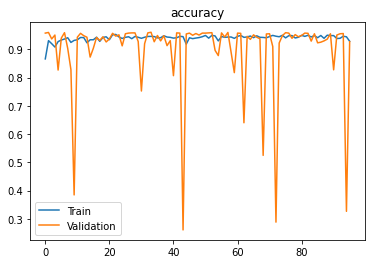

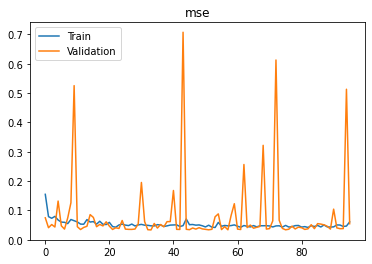

In [22]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)
early_stopping = [EarlyStopping(monitor='val_loss', patience=20),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

LAMBDA = 0.005
DROPOUT = 0.3

t0 = time.time()

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    callbacks=early_stopping, 
                    epochs=500, 
                    validation_data=(x_val_flat, y_val), verbose=2)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

print('Full runtime:', time.time() - t0)